In [170]:
import pandas as pd
import numpy as np
import time
import os.path as path
from ast import literal_eval
from itertools import product
import matplotlib.pyplot as plt

In [2]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

/Users/sijiazong/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Prepare datasets(user_item_ratings, game_metadata, game_id_name_pairs)

- User item ratings

In [390]:
user_item_df = pd.read_csv("ratings.csv")

In [409]:
user_item_df.user_id.nunique()

70329

In [408]:
user_item_df.item_id.nunique()

10974

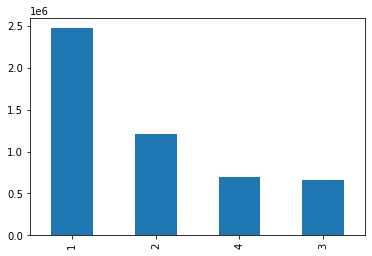

In [391]:
pd.value_counts(user_item_df['rating']).plot(kind="bar")

- Games Metadata

In [247]:
games = pd.read_csv("games_metadata.csv")

In [248]:
games.price.value_counts()

4.99      4278
9.99      3902
2.99      3429
0.99      2607
1.99      2541
          ... 
109.99       1
10.49        1
771.71       1
179.00       1
41.99        1
Name: price, Length: 145, dtype: int64

In [249]:
# create feature for game price category
bins = [-1, 0, 10, 60, 1000]
labels= ['Free', 'Low', 'Midum', 'High']
games['price_category'] = pd.cut(games['price'], bins=bins, labels=labels)

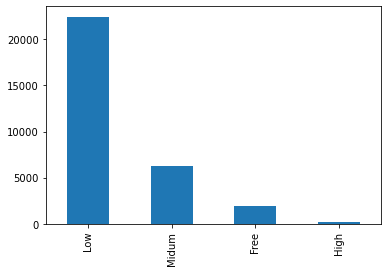

In [250]:
pd.value_counts(games['price_category']).plot(kind="bar")

In [251]:
# create feature for game release year
games['release_year'] = games['release_date'].apply(lambda s: pd.to_datetime(s, errors='coerce').year)

In [252]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32131 entries, 0 to 32130
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   publisher       24071 non-null  object  
 1   genres          28849 non-null  object  
 2   app_name        32131 non-null  object  
 3   title           30083 non-null  object  
 4   url             32131 non-null  object  
 5   release_date    30065 non-null  object  
 6   tags            31969 non-null  object  
 7   discount_price  224 non-null    float64 
 8   reviews_url     32131 non-null  object  
 9   specs           31462 non-null  object  
 10  price           30747 non-null  float64 
 11  early_access    32131 non-null  bool    
 12  id              32131 non-null  float64 
 13  developer       28834 non-null  object  
 14  sentiment       24950 non-null  object  
 15  metascore       2605 non-null   float64 
 16  item_id         2334 non-null   float64 
 17  bundles     

- All game id/name pair in both metadata/useritem pair

In [253]:
all_games = pd.read_csv("all_games_id_name_pair.csv")

## Building functions to generate item features data

In [256]:
# view list of features for consideration
games[['publisher', 'developer', 'genres', 'tags', 'specs', 'bundles', 'price', 'release_year']]

,publisher,developer,genres,tags,specs,bundles,price,release_year
0,Kotoshiro,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],NaN,4.99,2018.0
1,"Making Fun, Inc.",Secret Level SRL,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",NaN,0.00,2018.0
2,Poolians.com,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",NaN,0.00,2017.0
3,彼岸领域,彼岸领域,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']",['Single-player'],NaN,0.99,2017.0
4,NaN,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",NaN,2.99,NaN
...,...,...,...,...,...,...,...,...
32126,Ghost_RUS Games,"Nikita ""Ghost_RUS""","['Casual', 'Indie', 'Simulation', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation']","['Single-player', 'Steam Achievements']",NaN,1.99,2018.0
32127,Sacada,Sacada,"['Casual', 'Indie', 'Strategy']","['Strategy', 'Indie', 'Casual']","['Single-player', 'Steam Achievements', 'Steam...",NaN,4.99,2018.0
32128,Laush Studio,Laush Dmitriy Sergeevich,"['Indie', 'Racing', 'Simulation']","['Indie', 'Simulation', 'Racing']","['Single-player', 'Steam Achievements', 'Steam...",NaN,1.99,2018.0
32129,SIXNAILS,"xropi,stev3ns","['Casual', 'Indie']","['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","['Single-player', 'Steam Achievements', 'Steam...",NaN,4.99,2017.0


In [19]:
# Unique values for features
# price_category: 4
# specs: 40
# genres: 22
# tags: 339
# genres + specs: 62(genres and specs are uniquely different)
# genres + tags: 342(a lot of tags are in genres)
# release_year: 43
# bundles: 567

In [343]:
def build_game_features_list(item_features_cols):
    total_features = set()
    game_features_list = []
    for row in games.itertuples(index=False):
        features = set()
        for col in item_features_cols:
            val = getattr(row, col)
            if pd.isnull(val):
                continue
            if col in {"genres", "tags", "specs", "bundles"}:
                features.update(literal_eval(val))
            else:
                features.add(val)
        game_features_list.append(list(features))
        total_features.update(features)
    return game_features_list, list(total_features)

In [273]:
def getGameFeaturesData(item_features_cols):
    game_features_list, total_features = build_game_features_list(item_features_cols)
    game_tuple = list(zip(games.id, game_features_list))
    return (total_features, game_tuple)

## Building lightFM model

### 1. Building dataset, create interactions matrix, user featurer and split interactions matrix into train/test

dataset1 - pure CF dataset, dataset2 - Hybrid, add item features, need to rebuild dataset2 if selected feature changes

**PureCF(Only Collaborative Filtering)**

- build dataset

In [550]:
dataset0 = Dataset()
dataset0.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"])

- build interaction matrix

In [551]:
# add weight with ratings
(interactions0, weights0) = dataset0.build_interactions([(x[0], x[1]) for x in user_item_df.values])

In [552]:
# (68403, 33917) for user and item
interactions0.shape

(70329, 33917)

**Hybrid(Collaborative Filtering with item features)**

- Create features data for Features1(['genres'])

In [442]:
item_features_cols1 = ['genres']
total_features1, game_tuple1 = getGameFeaturesData(item_features_cols1)
len(total_features1)

22

- Create features data for Features2(['genres', 'bundles'])

In [443]:
item_features_cols2 = ['genres', 'bundles']
total_features2, game_tuple2 = getGameFeaturesData(item_features_cols2)
len(total_features2)

589

- Create features data for Features3(['genres', 'price', 'release_year'])

In [444]:
item_features_cols3 = ['genres', 'price', 'release_year']
total_features3, game_tuple3 = getGameFeaturesData(item_features_cols3)
len(total_features3)

210

- Build dataset

In [445]:
dataset1 = Dataset()
dataset1.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features1)
dataset2 = Dataset()
dataset2.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features2)
dataset3 = Dataset()
dataset3.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features3)

- build interaction matrix

In [446]:
(interactions1, weights1) = dataset1.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions1.shape)
(interactions2, weights2) = dataset2.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions2.shape)
(interactions3, weights3) = dataset3.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions3.shape)

(70329, 33917)
(70329, 33917)
(70329, 33917)


- build item features

In [453]:
item_features1 = dataset1.build_item_features(game_tuple1)
item_features2 = dataset2.build_item_features(game_tuple2)
item_features3 = dataset3.build_item_features(game_tuple3)

In [549]:
print(dataset1.item_features_shape())
print(dataset2.item_features_shape())
print(dataset3.item_features_shape())

(33917, 33939)
(33917, 34506)
(33917, 34122)


### 2. Train Test Split

- PureCF

In [553]:
train_interactions0, test_interactions0 = random_train_test_split(interactions0, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights0, test_weights0 = random_train_test_split(weights0, test_percentage=0.2, random_state=np.random.RandomState(3))

- Hybrid

In [456]:
train_interactions1, test_interactions1 = random_train_test_split(interactions1, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights1, test_weights1 = random_train_test_split(weights1, test_percentage=0.2, random_state=np.random.RandomState(3))

In [457]:
train_interactions2, test_interactions2 = random_train_test_split(interactions2, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights2, test_weights2 = random_train_test_split(weights2, test_percentage=0.2, random_state=np.random.RandomState(3))

In [458]:
train_interactions3, test_interactions3 = random_train_test_split(interactions3, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights3, test_weights3 = random_train_test_split(weights3, test_percentage=0.2, random_state=np.random.RandomState(3))

### 3. Build, fit and evaluate model in Hyperparameter Search

- Hyperparameter Search code is adapted from https://github.com/bcc008/ucsd-dse-capstone-c4g4/blob/master/notebooks/hyperparameter_search.ipynb
- Save all hyperparameter search results into csv for later comparision

In [459]:
# read hyperparameter search csv
if path.exists('lightfm_param_search.csv'):
   param_search_df = pd.read_csv('lightfm_param_search.csv')
else:
   param_search_df = pd.DataFrame()

In [555]:
param_search_df.shape

(30, 20)

In [556]:
possible_parameters_cf = {
                        'no_components': np.arange(5, 35, 5),
#                         'no_components': [20,30,40,50,60,70,80],
#                         'learning_schedule': ['adagrad','adadelta'],
                        'loss': ['warp', 'bpr'],
#                         'loss': ['bpr','warp'],
#                         'learning_rate': [0.05,0.01],
#                         'rho': [0.99,0.97,0.95,0.92,0.90,0.87,0.85,0.82,0.80],
#                         'epsilon': [1e-3,1e-04,1e-05,1e-06,1e-07],
#                         'item_alpha': [0, 0.01, 0.1],
#                         'item_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
#                         'user_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                        'random_state': [1]
                        }

In [491]:
possible_parameters_hybrid = {
                        'no_components': np.arange(5, 100, 10),
#                         'no_components': [20,30,40,50,60,70,80],
#                         'learning_schedule': ['adagrad','adadelta'],
                        'loss': ['warp'],
#                         'loss': ['bpr','warp'],
#                         'learning_rate': [0.05,0.01],
#                         'rho': [0.99,0.97,0.95,0.92,0.90,0.87,0.85,0.82,0.80],
#                         'epsilon': [1e-3,1e-04,1e-05,1e-06,1e-07],
#                         'item_alpha': [0, 0.01, 0.1],
#                         'item_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
#                         'user_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                        'random_state': [1]
                        }

In [476]:
def getParameterCombinations(possible_parameters):
    return [dict(zip(possible_parameters.keys(), values)) for values in product(*possible_parameters.values())]

In [558]:
parameter_combinations_cf = getParameterCombinations(possible_parameters_cf)
parameter_combinations_cf

[{'no_components': 5, 'loss': 'warp', 'random_state': 1},
 {'no_components': 5, 'loss': 'bpr', 'random_state': 1},
 {'no_components': 10, 'loss': 'warp', 'random_state': 1},
 {'no_components': 10, 'loss': 'bpr', 'random_state': 1},
 {'no_components': 15, 'loss': 'warp', 'random_state': 1},
 {'no_components': 15, 'loss': 'bpr', 'random_state': 1},
 {'no_components': 20, 'loss': 'warp', 'random_state': 1},
 {'no_components': 20, 'loss': 'bpr', 'random_state': 1},
 {'no_components': 25, 'loss': 'warp', 'random_state': 1},
 {'no_components': 25, 'loss': 'bpr', 'random_state': 1},
 {'no_components': 30, 'loss': 'warp', 'random_state': 1},
 {'no_components': 30, 'loss': 'bpr', 'random_state': 1}]

In [493]:
parameter_combinations_hybrid = getParameterCombinations(possible_parameters_hybrid)
len(parameter_combinations_hybrid)

10

In [494]:
def hyperparameter_search(model_name, parameter_combinations, train_interactions, test_interactions, item_features=None, k=10, epochs=5, num_threads=2, verbose=False):
    for parameters in parameter_combinations:
        start_time = time.time()
        model = LightFM(**parameters)
        model.fit(train_interactions, 
                  item_features=item_features,
                  epochs=epochs,
                  num_threads=num_threads)
        auc_train = auc_score(model, train_interactions, item_features=item_features, num_threads=num_threads).mean()
        auc_test = auc_score(model, test_interactions, item_features=item_features, num_threads=num_threads).mean()
        precision_train = precision_at_k(model, train_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
        precision_test = precision_at_k(model, test_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
        params = model.get_params()
        params['model_name'] = model_name
        params['auc_train'] = auc_train
        params['auc_test'] = auc_test
        params['@K'] = k
        params['MAP_train'] = precision_train
        params['MAP_test'] = precision_test
        params['epochs'] = epochs
        params['time'] = time.time() - start_time
        global param_search_df
        param_search_df = param_search_df.append(params, ignore_index=True)
        if verbose==True:
            print('Training complete for one set of parameters. Time taken: {}'.format(params['time']))

- PureCF

In [ ]:
hyperparameter_search("PureCF", parameter_combinations_cf, train_interactions0, test_interactions0, verbose=True)

Training complete for one set of parameters. Time taken: 336.206552028656
Training complete for one set of parameters. Time taken: 398.7235469818115
Training complete for one set of parameters. Time taken: 427.32046699523926


In [392]:
param_search_df.to_csv("lightfm_param_search.csv")

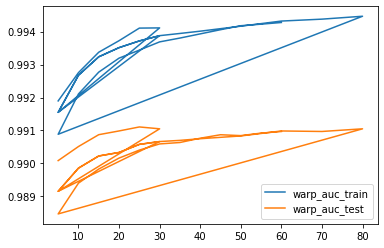

In [365]:
x1 = param_search_df[param_search_df.loss=="warp"].no_components
y1 = param_search_df[param_search_df.loss=="warp"].auc_train
plt.plot(x1, y1, label = "warp_auc_train")
x2 = param_search_df[param_search_df.loss=="warp"].no_components
y2 = param_search_df[param_search_df.loss=="warp"].auc_test
plt.plot(x2, y2, label = "warp_auc_test")
plt.legend()
plt.show()

no_components = 25 is best for warp

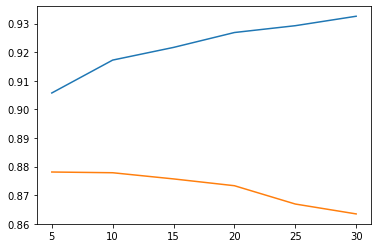

In [179]:
x3 = param_search_df[param_search_df.loss=="bpr"].no_components
y3 = param_search_df[param_search_df.loss=="bpr"].auc_train
plt.plot(x3, y3, label = "bpr_auc_train")
x4 = param_search_df[param_search_df.loss=="bpr"].no_components
y4 = param_search_df[param_search_df.loss=="bpr"].auc_test
plt.plot(x4, y4, label = "bpr_auc_test")

no_components = 5 is best for bpr

Generally warp is better than bpr for test result.

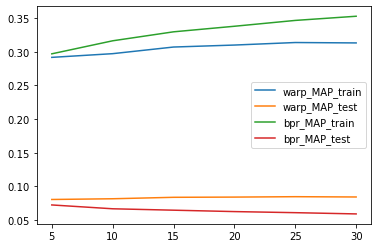

In [177]:
x1 = param_search_df[param_search_df.loss=="warp"].no_components
y1 = param_search_df[param_search_df.loss=="warp"].MAP_train
plt.plot(x1, y1, label = "warp_MAP_train")
x2 = param_search_df[param_search_df.loss=="warp"].no_components
y2 = param_search_df[param_search_df.loss=="warp"].MAP_test
plt.plot(x1, y2, label = "warp_MAP_test")
x3 = param_search_df[param_search_df.loss=="bpr"].no_components
y3 = param_search_df[param_search_df.loss=="bpr"].MAP_train
plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[param_search_df.loss=="bpr"].no_components
y4 = param_search_df[param_search_df.loss=="bpr"].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()

- Hybrid

In [496]:
hyperparameter_search("Hybrid_features1", parameter_combinations_hybrid, train_interactions1, test_interactions1, item_features=item_features1,verbose=True)

Training complete for one set of parameters. Time taken: 457.2211310863495
Training complete for one set of parameters. Time taken: 647.066342830658
Training complete for one set of parameters. Time taken: 880.1273007392883
Training complete for one set of parameters. Time taken: 567.1774499416351
Training complete for one set of parameters. Time taken: 819.3927149772644
Training complete for one set of parameters. Time taken: 1092.102366924286
Training complete for one set of parameters. Time taken: 750.1956307888031
Training complete for one set of parameters. Time taken: 874.3089878559113
Training complete for one set of parameters. Time taken: 1141.7160398960114
Training complete for one set of parameters. Time taken: 1341.2618267536163


In [497]:
hyperparameter_search("Hybrid_features2", parameter_combinations_hybrid, train_interactions2, test_interactions2, item_features=item_features2,verbose=True)

Training complete for one set of parameters. Time taken: 456.5545220375061
Training complete for one set of parameters. Time taken: 646.4406852722168
Training complete for one set of parameters. Time taken: 874.3763136863708
Training complete for one set of parameters. Time taken: 566.8845760822296
Training complete for one set of parameters. Time taken: 803.7682530879974
Training complete for one set of parameters. Time taken: 1048.304846048355
Training complete for one set of parameters. Time taken: 707.4655950069427
Training complete for one set of parameters. Time taken: 881.5830526351929
Training complete for one set of parameters. Time taken: 1151.241140127182
Training complete for one set of parameters. Time taken: 1400.832974910736


In [498]:
hyperparameter_search("Hybrid_features3", parameter_combinations_hybrid, train_interactions3, test_interactions3, item_features=item_features3, verbose=True)

Training complete for one set of parameters. Time taken: 515.4220740795135
Training complete for one set of parameters. Time taken: 787.772088766098
Training complete for one set of parameters. Time taken: 1090.1727731227875
Training complete for one set of parameters. Time taken: 670.1636900901794
Training complete for one set of parameters. Time taken: 1014.0559151172638
Training complete for one set of parameters. Time taken: 1308.8988630771637
Training complete for one set of parameters. Time taken: 780.606064081192
Training complete for one set of parameters. Time taken: 1196.42147397995
Training complete for one set of parameters. Time taken: 1521.4225010871887
Training complete for one set of parameters. Time taken: 1824.3154129981995


In [543]:
param_search_df

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,learning_schedule,loss,max_sampled,model_name,n,no_components,random_state,rho,time,user_alpha
12,10.0,0.108827,0.401646,0.988472,0.990795,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,5.0,RandomState(MT19937),0.95,457.221131,0.0
13,10.0,0.115155,0.427907,0.989844,0.992551,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,15.0,RandomState(MT19937),0.95,647.066343,0.0
14,10.0,0.115815,0.431710,0.990156,0.993025,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,25.0,RandomState(MT19937),0.95,880.127301,0.0
15,10.0,0.116572,0.434644,0.990384,0.993299,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,35.0,RandomState(MT19937),0.95,567.177450,0.0
16,10.0,0.117222,0.436463,0.990625,0.993617,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,45.0,RandomState(MT19937),0.95,819.392715,0.0
17,10.0,0.116838,0.437103,0.990606,0.993647,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,55.0,RandomState(MT19937),0.95,1092.102367,0.0
18,10.0,0.117014,0.438684,0.990735,0.993786,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,65.0,RandomState(MT19937),0.95,750.195631,0.0
19,10.0,0.117159,0.438395,0.990814,0.993891,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,75.0,RandomState(MT19937),0.95,874.308988,0.0
20,10.0,0.117341,0.440259,0.990895,0.993986,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,85.0,RandomState(MT19937),0.95,1141.716040,0.0
21,10.0,0.117455,0.441285,0.990935,0.994082,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features1,10.0,95.0,RandomState(MT19937),0.95,1341.261827,0.0


In [542]:
param_search_df.drop(param_search_df[param_search_df.model_name == "PureCF"].index, inplace=True)

In [538]:
param_search_df[(param_search_df.model_name == "PureCF")].describe()
#  & (param_search_df.loss=="warp")

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,12.0,12.000000,12.000000,12.000000,12.000000,12.0,1.200000e+01,12.0,12.0,1.200000e+01,12.0,12.0,12.000000,1.200000e+01,12.000000,12.0
mean,10.0,0.106441,0.464451,0.952866,0.965767,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,17.500000,9.500000e-01,489.314131,0.0
std,0.0,0.012460,0.040790,0.039122,0.028736,0.0,2.211743e-22,0.0,0.0,7.247438e-18,0.0,0.0,8.918826,1.159590e-16,107.853006,0.0
min,10.0,0.088956,0.425823,0.910289,0.925825,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,9.500000e-01,343.149504,0.0
25%,10.0,0.095526,0.433582,0.916694,0.943075,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,10.000000,9.500000e-01,421.203528,0.0
50%,10.0,0.110041,0.442942,0.954631,0.969693,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,17.500000,9.500000e-01,467.228391,0.0
75%,10.0,0.118228,0.498141,0.990333,0.992780,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,25.000000,9.500000e-01,579.667491,0.0
max,10.0,0.119133,0.538287,0.990747,0.993647,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,30.000000,9.500000e-01,656.694250,0.0


In [546]:
param_search_df[param_search_df.model_name == "Hybrid_features1"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,10.0,10.000000,10.000000,10.000000,10.000000,10.0,1.000000e+01,10.0,10.0,1.000000e+01,10.0,10.0,10.000000,10.00,10.000000,10.0
mean,10.0,0.115940,0.432810,0.990347,0.993268,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,857.056979,0.0
std,0.0,0.002603,0.011665,0.000743,0.000988,0.0,2.232128e-22,0.0,0.0,7.314236e-18,0.0,0.0,30.276504,0.00,273.332150,0.0
min,10.0,0.108827,0.401646,0.988472,0.990795,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,0.95,457.221131,0.0
25%,10.0,0.116004,0.432444,0.990213,0.993094,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,27.500000,0.95,672.848665,0.0
50%,10.0,0.116926,0.436783,0.990616,0.993632,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,846.850851,0.0
75%,10.0,0.117206,0.438612,0.990795,0.993865,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,72.500000,0.95,1039.108600,0.0
max,10.0,0.117455,0.441285,0.990935,0.994082,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,95.000000,0.95,1341.261827,0.0


In [547]:
param_search_df[param_search_df.model_name == "Hybrid_features2"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,10.0,10.000000,10.000000,10.000000,10.000000,10.0,1.000000e+01,10.0,10.0,1.000000e+01,10.0,10.0,10.000000,10.00,10.000000,10.0
mean,10.0,0.116265,0.433925,0.990419,0.993326,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,853.745196,0.0
std,0.0,0.002486,0.011878,0.000727,0.000977,0.0,2.232128e-22,0.0,0.0,7.314236e-18,0.0,0.0,30.276504,0.00,285.537105,0.0
min,10.0,0.109792,0.403840,0.988648,0.990950,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,0.95,456.554522,0.0
25%,10.0,0.116389,0.433281,0.990294,0.993169,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,27.500000,0.95,661.696913,0.0
50%,10.0,0.117174,0.437696,0.990664,0.993641,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,839.072283,0.0
75%,10.0,0.117584,0.441199,0.990869,0.993914,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,72.500000,0.95,1006.624398,0.0
max,10.0,0.117842,0.442975,0.991018,0.994181,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,95.000000,0.95,1400.832975,0.0


In [548]:
param_search_df[param_search_df.model_name == "Hybrid_features3"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,10.0,10.000000,10.000000,10.000000,10.000000,10.0,1.000000e+01,10.0,10.0,1.000000e+01,10.0,10.0,10.000000,10.00,10.000000,10.0
mean,10.0,0.114768,0.431142,0.990135,0.993117,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,1070.925086,0.0
std,0.0,0.003083,0.014597,0.000978,0.001233,0.0,2.232128e-22,0.0,0.0,7.314236e-18,0.0,0.0,30.276504,0.00,405.542763,0.0
min,10.0,0.106331,0.392252,0.987706,0.990099,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,0.95,515.422074,0.0
25%,10.0,0.114668,0.429783,0.989954,0.992903,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,27.500000,0.95,782.397570,0.0
50%,10.0,0.115785,0.436169,0.990497,0.993537,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,50.000000,0.95,1052.114344,0.0
75%,10.0,0.116402,0.439329,0.990744,0.993916,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,72.500000,0.95,1280.779516,0.0
max,10.0,0.116770,0.441862,0.990950,0.994169,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,95.000000,0.95,1824.315413,0.0


In [501]:
param_search_df[param_search_df.model_name == "Hybrid_features2"].sort_values(by="auc_test", ascending=False)

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,learning_schedule,loss,max_sampled,model_name,n,no_components,random_state,rho,time,user_alpha
31,10.0,0.117571,0.442975,0.991018,0.994181,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,95.0,RandomState(MT19937),0.95,1400.832975,0.0
30,10.0,0.117790,0.441445,0.990991,0.994073,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,85.0,RandomState(MT19937),0.95,1151.241140,0.0
29,10.0,0.117589,0.441318,0.990886,0.993938,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,75.0,RandomState(MT19937),0.95,881.583053,0.0
28,10.0,0.117842,0.440840,0.990819,0.993843,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,65.0,RandomState(MT19937),0.95,707.465595,0.0
27,10.0,0.117227,0.438557,0.990707,0.993742,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,55.0,RandomState(MT19937),0.95,1048.304846,0.0
26,10.0,0.117068,0.436834,0.990621,0.993541,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,45.0,RandomState(MT19937),0.95,803.768253,0.0
25,10.0,0.117121,0.436489,0.990469,0.993432,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,35.0,RandomState(MT19937),0.95,566.884576,0.0
24,10.0,0.116162,0.432212,0.990236,0.993082,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,25.0,RandomState(MT19937),0.95,874.376314,0.0
23,10.0,0.114492,0.424737,0.989791,0.992475,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,15.0,RandomState(MT19937),0.95,646.440685,0.0
22,10.0,0.109792,0.403840,0.988648,0.990950,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features2,10.0,5.0,RandomState(MT19937),0.95,456.554522,0.0


In [502]:
param_search_df[param_search_df.model_name == "Hybrid_features3"].sort_values(by="auc_test", ascending=False)

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,learning_schedule,loss,max_sampled,model_name,n,no_components,random_state,rho,time,user_alpha
41,10.0,0.116529,0.441862,0.990950,0.994169,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,95.0,RandomState(MT19937),0.95,1824.315413,0.0
40,10.0,0.116506,0.439815,0.990807,0.993986,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,85.0,RandomState(MT19937),0.95,1521.422501,0.0
39,10.0,0.116770,0.440026,0.990760,0.993945,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,75.0,RandomState(MT19937),0.95,1196.421474,0.0
38,10.0,0.116090,0.437872,0.990698,0.993831,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,65.0,RandomState(MT19937),0.95,780.606064,0.0
37,10.0,0.115780,0.436630,0.990566,0.993620,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,55.0,RandomState(MT19937),0.95,1308.898863,0.0
36,10.0,0.115789,0.435707,0.990428,0.993455,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,45.0,RandomState(MT19937),0.95,1014.055915,0.0
35,10.0,0.115081,0.432930,0.990157,0.993171,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,35.0,RandomState(MT19937),0.95,670.163690,0.0
34,10.0,0.114530,0.428734,0.989886,0.992814,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,25.0,RandomState(MT19937),0.95,1090.172773,0.0
33,10.0,0.114277,0.425595,0.989388,0.992087,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,15.0,RandomState(MT19937),0.95,787.772089,0.0
32,10.0,0.106331,0.392252,0.987706,0.990099,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,Hybrid_features3,10.0,5.0,RandomState(MT19937),0.95,515.422074,0.0


In [302]:
param_search_df.columns

Index(['@K', 'MAP_test', 'MAP_train', 'auc_test', 'auc_train', 'epochs',
       'epsilon', 'item_alpha', 'k', 'learning_rate', 'learning_schedule',
       'loss', 'max_sampled', 'model_name', 'n', 'no_components',
       'random_state', 'rho', 'time', 'user_alpha'],
      dtype='object')

- Hybrid graph

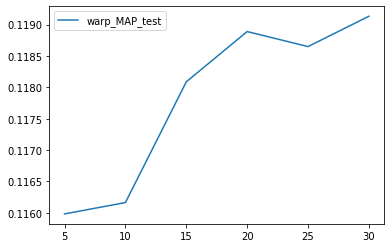

In [539]:
# x1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="PureCF")].no_components
# y1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="PureCF")].MAP_train
# plt.plot(x1, y1, label = "warp_MAP_train")
x2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="PureCF")].no_components
y2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="PureCF")].MAP_test
plt.plot(x2, y2, label = "warp_MAP_test")
plt.legend()
plt.show()

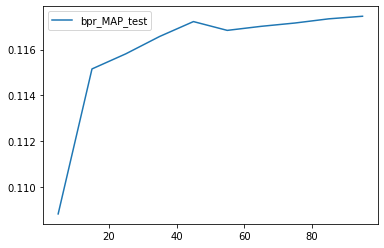

In [522]:
# x3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].no_components
# y3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].MAP_train
# plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features1")].no_components
y4 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features1")].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()

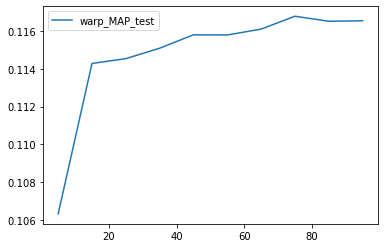

In [523]:
# x1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features1")].no_components
# y1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features1")].MAP_train
# plt.plot(x1, y1, label = "warp_MAP_train")
x2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features3")].no_components
y2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features3")].MAP_test
plt.plot(x2, y2, label = "warp_MAP_test")
plt.legend()
plt.show()

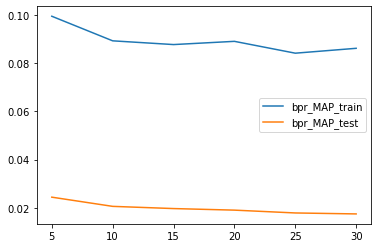

In [316]:
x3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
y3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_train
plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
y4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()

## Model Evaluation using MAP@K
Mean average precision(MAP)@K and AUC score for train and test

In [ ]:
train_auc = auc_score(pure_cf, train_interactions).mean()
test_auc = auc_score(pure_cf, test_interactions).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
train_precision = precision_at_k(pure_cf, train_interactions, k=10).mean()
test_precision = precision_at_k(pure_cf, test_interactions,k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

In [ ]:
train_auc = auc_score(hybrid_model, train_interactions, item_features=item_features).mean()
test_auc = auc_score(hybrid_model, test_interactions, item_features=item_features).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
train_precision = precision_at_k(hybrid_model, train_interactions, item_features=item_features, k=10).mean()
test_precision = precision_at_k(hybrid_model, test_interactions, item_features=item_features, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

## Make recommendations

- get userid/itemid/features mappings

In [ ]:
# set the dataset to the final model dataset
dataset = dataset1

In [ ]:
# mappings: (user id map, user feature map, item id map, item feature map)
mapping = dataset.mapping()

In [ ]:
item_features_mapping = mapping[3]
item_features_mapping

In [ ]:
# series used to use index(internal id) to locate the real id
user_series = pd.Series(mapping[0])
item_series = pd.Series(mapping[2])

In [ ]:
def getInternalId(real_id, series):
    return series[real_id]

In [ ]:
def getRawId(internal_id, series):
    return series[series == internal_id].index[0]

In [245]:
# raw id to internal id
getInternalId(76561198007712555, user_series)

NameError: name 'getInternalId' is not defined

In [ ]:
getRawId(68398, user_series)

- Make recommendations

In [ ]:
# print("Train precision: %.2f" % precision_at_k(pure_cf, data['train'], k=5).mean())
# print("Test precision: %.2f" % precision_at_k(pure_cf, data['test'], k=5).mean())

In [ ]:
user_id = 76561197970982479

In [ ]:
n_users, n_items = interactions.shape
internal_user_id = getInternalId(user_id, user_series)
all_scores = pd.Series(hybrid_model.predict(internal_user_id, np.arange(n_items)))

In [ ]:
all_scores

In [ ]:
# scores.index = np.arange(n_items)
all_ranks = list(pd.Series(all_scores.sort_values(ascending=False).index))

In [ ]:
all_ranks

In [ ]:
known_items = user_item_df[user_item_df.user_id == user_id].item_id.sort_values()

In [ ]:
known_items_internal_ids = known_items.apply(getInternalId, args=(item_series,))

In [ ]:
ranks = [x for x in all_ranks if x not in known_items]

In [ ]:
ranks

In [ ]:
recommended_list = ranks[0:10]

In [ ]:
recommended_list_ids = [getRawId(id, item_series) for id in recommended_list]

In [ ]:
known_items_names = all_games.loc[all_games['item_id'].isin(known_items)]
known_items_names[:10]

In [ ]:
recommended_items_names = all_games.loc[all_games['item_id'].isin(recommended_list_ids)]
recommended_items_names